# Named Entity Extraction - Crypto Based


### What is the objective of the task?

We aim to extract the keyphrases from the text being provided.The text being provided is related to Crypto-currency terms.Hence we are looking for terms that are related to crypto-currency in the provided text.

### About the Data 

We are provided with 3 Files as follows - 

1. data.csv - These are texts scraped from telegram channels where crypto currency is discussed.This is the text on which we      have to perform keyphrase-extraction.

2. term_abb.csv - This file contains crypto terms with their abbrevations & what each of those abbrevation stands for.

3. term_definition - This file carries definition of various crypto related terms that are used in day to day basis.

The files term_abb & term_definition can be used to form base vocabulary for keyphrase extraction model.


### Installing Essential Packages

In [ ]:
# To plot word cloud of the important terms
#!pip install wordcloud

In [ ]:
#Installing Yake for classifying related words
!pip install git+https://github.com/LIAAD/yake

  Running command git clone -q https://github.com/LIAAD/yake 'C:\Users\Dinesh\AppData\Local\Temp\pip-req-build-phtulrha'


  Cloning https://github.com/LIAAD/yake to c:\users\dinesh\appdata\local\temp\pip-req-build-phtulrha
  Resolved https://github.com/LIAAD/yake to commit 6a37efc67912195aebed562cd943bca8acc48f64


## Importing Essential Packages

In [3]:
#To handle the dataset
import numpy as np
import pandas as pd

# To pre-process text data 
import nltk
import re
from re import sub
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#For converting words to vector
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

#For finding similarity between text
from gensim.similarities import WordEmbeddingSimilarityIndex, SoftCosineSimilarity

#For pickling Files & Models
import pickle

#For tracking the total number of iterations
from tqdm import tqdm
import os

#For counting frequency of words in a given text
from collections import Counter

#Importing math module for getting square root
from math import sqrt
    

#Yake for extracting key phrases
import yake

#For plotting plots & wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#For plotting Results Table
from prettytable import PrettyTable

In [4]:
# load dataset
test_text = pd.read_csv('C:/Users/Dinesh/Downloads/data.csv')

# visualise the dataset
test_text.head()

,id,content
0,321712,Hey 👋 \n\nWe re using our bot:\n\nhttps://t.me...
1,321713,Good stuff \n\nI am surprised I took so long t...
2,321717,you are using a non-official one
3,321718,use the one that uniswap uses: https://thegrap...
4,321719,keep in mind this is a hot subgraph so it can ...


In [5]:
# rows and columns of the data
test_text.shape

(44136, 2)

# Cleaning Text 

### Checking for Nan Values in content column

In [6]:
# check if we have any nan values are there in the column
print(test_text['content'].isnull().values.any())
print("number of nan values",test_text['content'].isnull().values.sum())

True
number of nan values 650


In [7]:
#Filtering the rows which don't have null values
data = test_text[test_text['content'].notna()]

#Checking shape of the data after selecting not null values
data.shape

(43486, 2)

In [8]:
#Checking no nan values exist in the dataframe now
# check if we have any nan values are there in the column
print(data['content'].isnull().values.any())
print("number of nan values",data['content'].isnull().values.sum())

False
number of nan values 0


In [9]:
#Definition Function for text cleaning
def decontracted(phrase):
    """Performs text cleaning by removing stop-words,
       returns cleaned text which is free from stop-words"""
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
#Removing special symbols & numbers from the text
# https://gist.github.com/sebleier/554280
preprocessed_sent = []
# tqdm is for printing the status bar
for sentence in tqdm(data['content'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub(r'http\S+', '', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords.words('english'))
    preprocessed_sent.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 43486/43486 [01:51<00:00, 391.66it/s]


In [11]:
#Making sure the length of the pre-processed text is same after processing
len(preprocessed_sent)

43486

In [12]:
#Extracting Nouns from the pre-processed texts 
all_nouns = []
for lines in tqdm(preprocessed_sent):
# function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
# do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
    all_nouns.append(nouns)
print(len(all_nouns))

100%|██████████████████████████████████████████████████████████████████████████| 43486/43486 [00:32<00:00, 1325.10it/s]

43486


In [13]:
#Converting the above obtained list of lists into a single list
flat_list = [item for sublist in all_nouns for item in sublist]

In [15]:
#Saving the above obtained list as txt file to avoid repetition of the part covered till now
with open("flat_list_old.txt", "w") as f:
    for value in flat_list:
        f.write(str(value) +"\n")

In [18]:
#Converting the list of nouns into text
all_nouns_str_old = ' '.join(flat_list)

In [19]:
#Calculating the frequencies of the items in the list 
freq = Counter(all_nouns_str_old.split()).most_common()
print(freq)

[('i', 5492), ('com', 3993), ('twitter', 2984), ('status', 2871), ('people', 1693), ('anyone', 1248), ('time', 1099), ('way', 1051), ('chain', 994), ('something', 943), ('money', 838), ('crypto', 815), ('market', 798), ('price', 758), ('contract', 757), ('use', 718), ('thanks', 689), ('tokens', 667), ('someone', 651), ('data', 649), ('liquidity', 642), ('protocol', 636), ('wallet', 620), ('thing', 614), ('point', 609), ('case', 581), ('eth', 562), ('lol', 561), ('yeah', 560), ('users', 539), ('anything', 532), ('defi', 518), ('team', 516), ('work', 510), ('address', 509), ('projects', 504), ('things', 491), ('lot', 489), ('guys', 484), ('project', 479), ('risk', 467), ('community', 460), ('stuff', 453), ('pool', 451), ('funds', 444), ('question', 432), ('io', 429), ('everyone', 421), ('assets', 418), ('www', 417), ('network', 414), ('get', 413), ('value', 408), ('contracts', 403), ('yes', 398), ('governance', 393), ('ser', 393), ('idea', 393), ('problem', 385), ('discussion', 377), ('f

We notice there are some very common un-related words with high frequency like i, something, com, people etc

So we are removing these words manually.

In [ ]:
# Removing elements with frequency more than 1000
flat_list = [i for i in tqdm(flat_list) if flat_list.count(i) < 1000]
len(flat_list)

100%|█████████████████████████████████████████████████████████████████████████| 207239/207239 [18:35<00:00, 185.86it/s]


186808

In [ ]:
#Writing new flat list to the text file
with open("flat_list.txt", "w") as f:
    for value in flat_list:
        f.write(str(value) +"\n")

186808

In [ ]:
#Loading the nouns from the text file back to list
flat_list = []
with open("flat_list.txt", "r") as f:
    for line in f:
        flat_list.append(int(line.strip()))

In [ ]:
all_nouns_str = ' '.join(flat_list)
print(all_nouns_str)

hey lobster watcher recommendations topics attention day stuff community lol one thegraph service subgraph ianlapham arbitrum minimal mind subgraph change notice vestafinance money fact someone money mean judgement point r gov model voting solves verify identity holder hope guys www watch v h rtk1vbnvs vision project reality downwards kind bell curve traders governance forums model gas fee vote users governance rocket day forums days tbh votes sir gas fees kinda mental model thanks thanks guess contract chains balance io cabdyinn8ymlsn7ofkf dg ricburton token lfg jfc meme template bsc lol fi uxisdyctpvkm5vcymjmghg jfc account nft buy target eth pampu omfg balancer supply cost friend reference ricburton substack p balance accurate something interest lobsters part beta thank everyone fi web3 experience svelte learn react yea sveltekit dapps couple years something hang balance q hit contrib yeah fan svelte everything web3 bit svelte glad stake yield everything react dev love team fun sure

In [ ]:
#save text file
Noun_text_file = open("noun_data.txt", "w")
 
#write string to file
Noun_text_file.write(all_nouns_str)
 
#close file
Noun_text_file.close()

In [2]:
#open text file in read mode
text_file = open("noun_data.txt", "r")
 
#read whole file to a string
all_nouns_str = text_file.read()
 
#close file
text_file.close()

In [3]:
#Checking the count of words after removing high frequency un-related words
freq = Counter(all_nouns_str.split()).most_common()
print(freq)

[('chain', 994), ('something', 943), ('money', 838), ('crypto', 815), ('market', 798), ('price', 758), ('contract', 757), ('use', 718), ('thanks', 689), ('tokens', 667), ('someone', 651), ('data', 649), ('liquidity', 642), ('protocol', 636), ('wallet', 620), ('thing', 614), ('point', 609), ('case', 581), ('eth', 562), ('lol', 561), ('yeah', 560), ('users', 539), ('anything', 532), ('defi', 518), ('team', 516), ('work', 510), ('address', 509), ('projects', 504), ('things', 491), ('lot', 489), ('guys', 484), ('project', 479), ('risk', 467), ('community', 460), ('stuff', 453), ('pool', 451), ('funds', 444), ('question', 432), ('io', 429), ('everyone', 421), ('assets', 418), ('www', 417), ('network', 414), ('get', 413), ('value', 408), ('contracts', 403), ('yes', 398), ('governance', 393), ('ser', 393), ('idea', 393), ('problem', 385), ('discussion', 377), ('fees', 374), ('part', 373), ('gas', 371), ('code', 371), ('day', 369), ('guess', 367), ('nothing', 367), ('dao', 362), ('token', 361)

In [3]:
#Loading the crypto abbrevation file
crypto_abb = pd.read_csv('term_abb.csv')
crypto_abb.head()

,terms,abbreviations
0,Auroracoin,AUR
1,BitConnect (inactive),BCC
2,Bitcoin Cash,BCH
3,Bitcoin,BTCorXBT
4,Dash,DASH


In [4]:
#Merging the crypto terms & abbrevation into a single list
cryto_terms = []
for value in crypto_abb['terms']:
    cryto_terms.append(value)
for value in crypto_abb['abbreviations']:
    cryto_terms.append(value)
print(len(cryto_terms))

156


### Using yake to classify Nouns

In [ ]:
#Finding Keyphrase using Yake
unique_kw = []
title = "Identifying crypto related words"
kw_extractor = yake.KeywordExtractor(top=20, stopwords=None)
full_text = title + all_nouns_str
keywords = kw_extractor.extract_keywords(full_text)
for kw, v in keywords:
    unique_kw.append(kw)
    print("Keyphrase: ",kw, ": score", v)

Keyphrase:  discussion link discussion : score 4.486446798016577e-07
Keyphrase:  link link discussion : score 1.0654330606490353e-06
Keyphrase:  source telegram medium : score 1.0932284236468353e-06
Keyphrase:  link discussion discussion : score 1.16647616748431e-06
Keyphrase:  link discussion link : score 1.1719763667139386e-06
Keyphrase:  www theblockcrypto post : score 1.5170549804379268e-06
Keyphrase:  address address address : score 1.9302670796528384e-06
Keyphrase:  market market market : score 2.064704508599724e-06
Keyphrase:  day yield day : score 2.2954814396366503e-06
Keyphrase:  source rss medium : score 2.5057508397324017e-06
Keyphrase:  crypto link discussion : score 2.609958875363574e-06
Keyphrase:  github metamask metamask : score 2.6546527214196435e-06
Keyphrase:  end solution assets : score 2.8276365540530455e-06
Keyphrase:  supply chain attack : score 2.877686766177694e-06
Keyphrase:  yield day yield : score 3.039411714049757e-06
Keyphrase:  contract address contract 

In [ ]:
#Checking the similarity of yake provided words with the crypto-related words in corpus
threshold = 0.75
Final_crypto_kw = []
for key in unique_kw:
    for word in cryto_terms:
        try:
            res = cosdis(word2vec(key), word2vec(word))
            if res > threshold:
                print("Found a word with cosine distance > 75 : {} with original word: {}".format(key, word))
                Final_crypto_kw.append(key)
                unique_terms = set(Final_crypto_kw)
        except IndexError:
            pass

Found a word with cosine distance > 75 : link link discussion with original word: Technical Analysis or Trend Analysis
Found a word with cosine distance > 75 : source telegram medium with original word: Ethereum Classic
Found a word with cosine distance > 75 : source telegram medium with original word: Enterprise Ethereum Alliance
Found a word with cosine distance > 75 : source telegram medium with original word: Ethereum Improvement Proposal
Found a word with cosine distance > 75 : source telegram medium with original word: Distributed Ledger Technology
Found a word with cosine distance > 75 : source telegram medium with original word: Token standard for Ethereum
Found a word with cosine distance > 75 : source telegram medium with original word: Conventional government-issued currency (e.g. US Dollar, Euro)
Found a word with cosine distance > 75 : source telegram medium with original word: “Wrecked” (meaning major losses)
Found a word with cosine distance > 75 : link discussion link w

In [ ]:
#Checking the number of words provided by Rake as keyphrases
len(unique_terms)

11

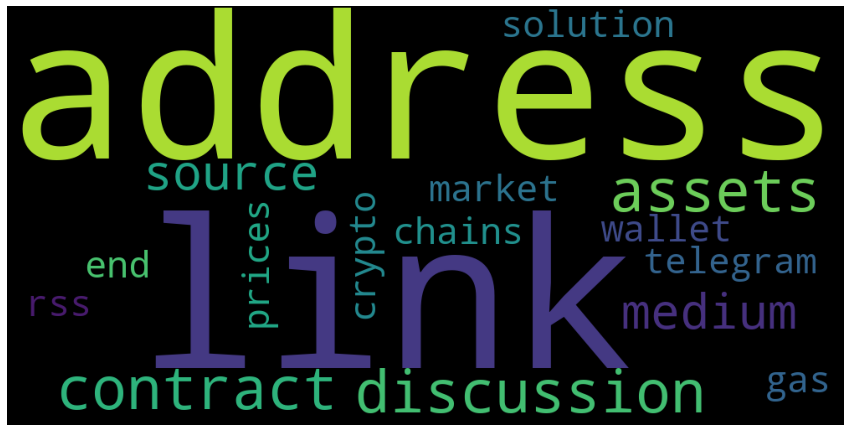

In [ ]:
#convert list to string and generate word cloud
unique_string=(" ").join(unique_terms)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

### Trying to Classify Key phrases using TextRank

In [ ]:
#Installing suma package thats required for using TextRank
!pip install summa

In [ ]:
#Extracting top 20 keywords using TextRank
from summa import keywords
title = "Identifying crypto related words"
full_text = title + all_nouns_str
TR_keywords = keywords.keywords(full_text, scores=True)
print(TR_keywords[0:20])

Tried using the text rank algorithm on Colab as well as on local machine with 8gb RAM multiple times.
It seems like due to the size of the corpus it always goes out of memory & then crashes the jupyter notebook.

But that's not an issue we can try something more advanced called keybert which looks more promising.

### Extracting keyphrases using keybert

In [5]:
#Installing the keybert package
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 235 kB 44.3 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 
     |████████████████████████████████| 4.9 MB 46.5 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
     |████████████████████████████████| 120 kB 60.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=9e70df60979eb08a76cc539207b48bb1b2b969305c9bc41287759c1c9c57987c
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [6]:
#Loading keyBERT model with embedding as all-mpnet-base-v2
from keybert import KeyBERT
kw_model = KeyBERT(model='all-mpnet-base-v2')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [7]:
#Extracting keywords from the nouns
title = "Identifying crypto related words"
full_text = title + all_nouns_str
keywords = kw_model.extract_keywords(full_text, 

                                     keyphrase_ngram_range=(1, 3), 

                                     stop_words='english', 

                                     highlight=False,

                                     top_n=30)

keywords_list= list(dict(keywords).keys())

print(keywords_list)

['crypto related wordshey', 'word lexicon bitcoiners', 'lexicon bitcoiners', 'lexicon bitcoiners ethereum', 'word crypto', 'words news bitcoin', 'thing word crypto', 'blockchain words', 'ethereum words', 'eth words', 'ethereum words investors', 'crypto community', 'cryptos term opinion', 'crypto sounds crypto', 'cryptojobslist dailyapehr lobsters', 'cryptojobslist dailyapehr', 'crypto holders crypto', 'recap devs crypto', 'things crypto non', 'words baldr crypto', 'crypto communities', 'naratives crypto stuff', 'crypto communities lobsterdao', 'ser crypto communities', 'crypto posts', 'tech insider cryptocom', 'identifying crypto related', 'articles crypto stuff', 'ideas medium crypto', 'crypto things']


Here we are saving the list of keyphrase provided by keybert so the GPU utilization on colab is minimum as we work futher

In [ ]:
#save text file
kw_file = open("file.txt", "w")
 
#write string to file
kw_file.write(keyword_list)
 
#close file
kw_file.close()

In [8]:
#Loading the 
with open("file.txt", 'r') as f:
    kw_list = [line.rstrip('\n') for line in f]

In [ ]:
kw_list

['lexicon bitcoiners',
 'word crypto',
 'blockchain words',
 'ethereum words',
 'eth words',
 'crypto community',
 'cryptojobslist dailyapehr',
 'crypto communities',
 'crypto posts',
 'crypto things',
 'words btc',
 'term crypto',
 'things crypto',
 'read crypto',
 'crypto subreddits',
 'cryptocurrency text',
 'recap crypto',
 'crypto news',
 'topic crypto',
 'crypto zeitgeist',
 'crypto nerds',
 'naratives crypto',
 'words investors',
 'terms crypto',
 'know cryptohayes',
 'crypto company',
 'heatherreyhan crypto',
 'crypto newcomers',
 'crypto',
 'coin crypto']

In [ ]:
def word2vec(word):
    
    """Computes the length of word vector,
       returns count of word characters, set of different characters, length of word vector"""
    
    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

In [ ]:
def cosdis(v1, v2):
    
    """Computes the cosine similarity,
       returns cosine similarity between two words"""
    
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]

In [ ]:
#Calculating the cosine distance between the keybert word & corpus word
import gensim
from gensim.models import Word2Vec
threshold = 0.75     # if needed
Final_crypto_kw = []
for key in kw_list:
    for word in cryto_terms:
        try:
            # print(key)
            # print(word)
            res = cosdis(word2vec(key), word2vec(word))
            # print(res)
            #print("The cosine similarity between : {} and : {} is: {}".format(word, key, res*100))
            if res > threshold:
                print("Found a word with cosine distance > 75 : {} with original word: {}".format(key, word))
                Final_crypto_kw.append(key)
                unique_terms = set(Final_crypto_kw)
        except IndexError:
            pass

Found a word with cosine distance > 75 : lexicon bitcoiners with original word: BitConnect (inactive)
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Bitcoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Litecoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Coinye (inactive)
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Peercoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Titcoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: USD Coin (stablecoin)
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Vertcoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Primecoin
Found a word with cosine distance > 75 : lexicon bitcoiners with original word: Bitcoin Improvement Proposal
Found a word with cosine distance > 75 : lexicon bitcoin

In [ ]:
#Printing Final words provided by keybert
print(unique_terms)

{'naratives crypto', 'crypto things', 'ethereum words', 'crypto newcomers', 'coin crypto', 'term crypto', 'read crypto', 'crypto news', 'things crypto', 'cryptocurrency text', 'crypto nerds', 'words investors', 'crypto zeitgeist', 'terms crypto', 'crypto subreddits', 'lexicon bitcoiners', 'eth words', 'crypto communities'}


In [ ]:
#Number of Unique keyphrases provided by KeyBert
len(kw_list)

30

In [ ]:
#Number of Unique keyphrases after comparing keybert words with cosine similarity of corpus
len(unique_terms)

18

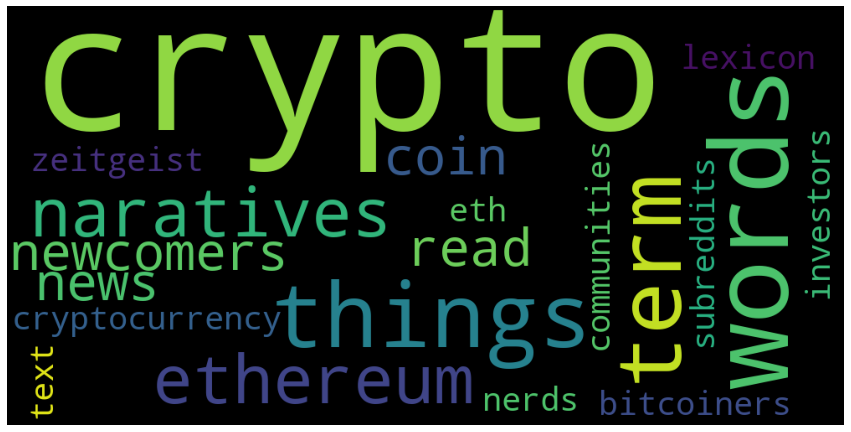

In [ ]:
#Making a word cloud for the keyphrases provided by KeyBert
#convert list to string and generate
unique_string=(" ").join(unique_terms)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

## Results

In [21]:
#Plotting Results Table
from prettytable import PrettyTable
x = PrettyTable() 
x.field_names = ["Sr.No.","Model Name", "Original No. of Key-phrases", "No. of Keyphrases after corpus comparison"] 
x.add_row(["1","Yake","30", "11"]) 
x.add_row(["2","KeyBERT","30", "18"]) 
print(x)

+--------+------------+-----------------------------+-------------------------------------------+
| Sr.No. | Model Name | Original No. of Key-phrases | No. of Keyphrases after corpus comparison |
+--------+------------+-----------------------------+-------------------------------------------+
|   1    |    Yake    |              30             |                     11                    |
|   2    |  KeyBERT   |              30             |                     18                    |
+--------+------------+-----------------------------+-------------------------------------------+


## Conclusion & Future work

1. Yake provided us with some optimal keyphrases that looked more or less related to corpus with the number of unique keyphrases provided being 11.


2. KeyBert not only provided more number of Keyphrases being 18 but also the words provided by KeyBERT were more significant than Yake.

Future Work 

We can try using state of the art models like GPT-3 which would yield us better results but these models comes as a paid service which we can say is somewhat their limiting factor.